In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer

In [5]:
df = pd.read_csv("../data/news_postprocess.csv", delimiter=";")
df.head()

,sentiment,text,sentiment_encoded
0,positive,"The apartment block will be well-located , in ...",2
1,neutral,The sale of the food potato business is part o...,1
2,positive,The Group 's business is balanced by its broad...,2
3,positive,TeliaSonera said about $ 100 million will be i...,2
4,neutral,The mall is part of the Baltic Pearl developme...,1


In [6]:
encoder = SentenceTransformer("yiyanghkust/finbert-tone")
embeddings = encoder.encode(df["text"].to_list(), show_progress_bar=True)
labels = df["sentiment_encoded"].values

No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.
Batches: 100%|██████████| 57/57 [00:13<00:00,  4.25it/s]


In [7]:
# creating a train test validation split
from sklearn.model_selection import train_test_split

# First split: Train+Val and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Check the shapes
print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (1159, 768)
Val shape: (290, 768)
Test shape: (363, 768)


In [8]:
# making the neural net
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


optimizer = Adam(learning_rate=0.0001)
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/abaziz/Documents/programming/portfolio-projects/stock-mood/backend/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,395 (419.51 KB)

 Trainable params: 107,139 (418.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3921 - loss: 2.2010 - val_accuracy: 0.7172 - val_loss: 1.1437
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5329 - loss: 1.7128 - val_accuracy: 0.7690 - val_loss: 0.9954
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 1.4868 - val_accuracy: 0.7931 - val_loss: 0.9170
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 1.3533 - val_accuracy: 0.8034 - val_loss: 0.8667
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 1.3003 - val_accuracy: 0.8138 - val_loss: 0.8394
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 1.3200 - val_accuracy: 0.8138 - val_loss: 0.8289
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 1.2747 - val_accuracy: 0.8310 - val_loss: 0.8159
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6778 - loss: 1.2265 - val_accuracy: 0.8345 - v

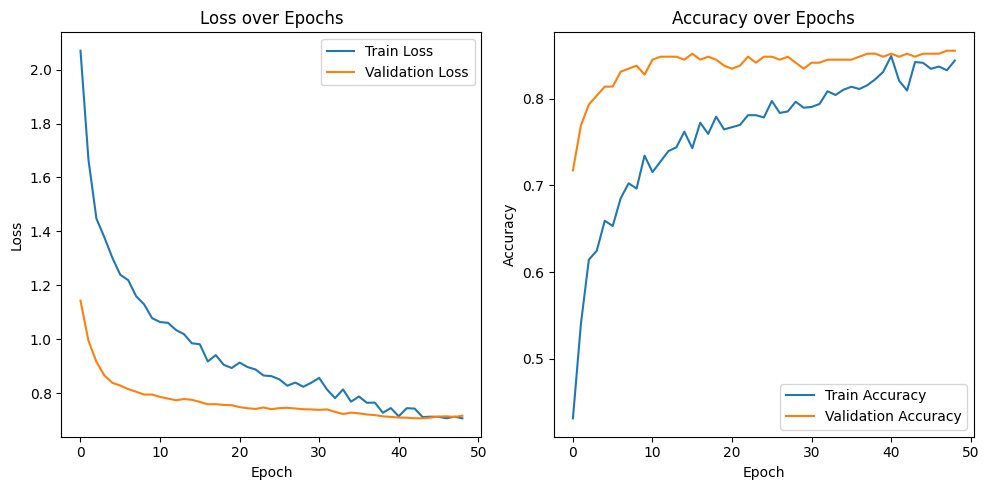

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
probs = model.predict(X_test)
y_pred = np.argmax(probs, axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.8181818181818182
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       121
     neutral       0.78      0.77      0.77       121
    positive       0.82      0.78      0.80       121

    accuracy                           0.82       363
   macro avg       0.82      0.82      0.82       363
weighted avg       0.82      0.82      0.82       363



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[85  8  3]
 [ 5 83  9]
 [ 8 11 78]]


In [16]:
# test
x1 = X_val[0].reshape(1, -1)
print(x1.shape)
pred = model.predict(x1)
print(pred)

(1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.98451185 0.00323686 0.0122513 ]]


In [13]:
# saving the model 
model.save("../models/model_v1.keras")